In [32]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

import IPython

def display(*dfs):
    for df in dfs:
        IPython.display.display(df)

In [33]:
if not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")
assert torch.cuda.is_available()
device = torch.device("cuda:0")

In [34]:
cudnn.benchmark = True
# torch.cuda.manual_seed(opt.seed)

# Data Loader

In [35]:
from PIL import Image
from os.path import join
import random

import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

def transformation_sample(a,b, dataset, index=None, name=None):
    a = transforms.ToTensor()(a)
    b = transforms.ToTensor()(b)
    a = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(a)
    b = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(b)

    # reverse img
    if random.random() < 0.5:
        idx = [i for i in range(a.size(2)-1, -1, -1)] # from 256 down to 0 with step 1
        idx = torch.LongTensor(idx)
        a = a.index_select(2, idx)
        b = b.index_select(2, idx)
        
    name = dataset.image_filenames[index] if index is not None else name
    if dataset.add_input:
        appartment_info = dataset.data[dataset.data.name==name]\
                        .drop(['name', 'test'], axis=1).values.reshape(-1,1)
        appartment_info = appartment_info[:,:, None].astype(np.float)
        appartment_info_img = torch.Tensor(appartment_info).repeat(1, a.shape[1], a.shape[2])
    else:
        appartment_info_img = torch.Tensor()

    return a,b, appartment_info_img, name
    

class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, image_filenames, n_type, 
                 df, add_input=True, img_fmt='png'):
        super(DatasetFromFolder, self).__init__()
        #self.direction = direction
        self.image_dir = image_dir
        self.a_path = '_256_1' + '.' + img_fmt#join(image_dir, "a")
        self.b_path = '_256_' + n_type + '.' + img_fmt #join(image_dir, "b")
        self.image_filenames = image_filenames
        self.data = df
        self.add_input = add_input 
       
        #[x for x in listdir(self.a_path) if is_image_file(x)]

#         transform_list = [transforms.ToTensor(),
#                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
#         self.transform = transforms.Compose(transform_list)

    def __getitem__(self, index):
        a = Image.open(join(self.image_dir, 
                            self.image_filenames[index]+self.a_path)).convert('RGB')
        b = Image.open(join(self.image_dir, 
                            self.image_filenames[index]+self.b_path)).convert('RGB')
        a,b,appartment_info_img, name = transformation_sample(a,b, self, index=index)
#         print(appartment_info_img.shape, name)
        return a,b, appartment_info_img, name
        
    def __len__(self):
        return len(self.image_filenames)


    
def get_sample_by_name(dataset, name):
        a = Image.open(join(dataset.image_dir, 
                            name + dataset.a_path)).convert('RGB')
        b = Image.open(join(dataset.image_dir, 
                            name + dataset.b_path)).convert('RGB')
        a,b,appartment_info_img, name = transformation_sample(a,b, dataset, 
                                                             name=name)
        return a,b, appartment_info_img, name

    
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def preprocess_appartment_data(df):
    train = df[df.test != True]
    to_ohe = ['n_rooms', 'restroom', 'studio', 'storeroom']
    ss = StandardScaler().fit(train[['area']])
    ohe = OneHotEncoder(drop='first', sparse=False).fit(train[to_ohe])
    
    df_ss = ss.transform(df[['area']])
    df_ohe = ohe.transform(df[to_ohe])
    df = pd.DataFrame(np.hstack([df[['name', 'test']], df_ss, df_ohe]),
                      columns=['name', 'test', 'area', 'n_rooms2', 'n_rooms3',
                               'restroom_separate', 'restroom_together',
                               'studio', 'storeroom'])
    return df, ss, ohe
    
def get_dataset(root_dir, df, n_type, add_input, test=False):
    df = df[df.test==True] if test else df[df.test==False]
    filenames = df.name.tolist()
    tmp = f'Test' if test else f'Train'
    tmp += f' size:\t{len(filenames):5d}'
    print(tmp)
    return DatasetFromFolder(root_dir, filenames, n_type, df, add_input=add_input)


def postprocees_img(img_tensor):
    img = img_tensor.data.cpu().float().numpy()
    img = (np.transpose(img, (1,2,0)) + 1.) / 2. * 255.
    return img.astype(np.uint8)

# df_prep, ss, ohe = preprocess_appartment_data(df)

# plt.ion()
# d = get_dataset(root_path, df_prep, '1', add_input=False)
# plt.imshow(postprocees_img(d[9][0]))

In [36]:
d[9][0].shape, d[0][2].shape

NameError: name 'd' is not defined

In [37]:
d = get_dataset(root_path, df_prep, '1', add_input=True)
d

Train size:	  108


In [38]:
b = torch.Tensor()
a = torch.ones(1,3,256,256)
torch.cat([a,b], 1).shape

torch.Size([1, 3, 256, 256])

# Generator

In [39]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
# from torch.optim import lr_scheduler

def define_Ublock(in_c, out_c, name, transposed=False, 
                  batchnorm=True, relu=True, tanh=False, dropout=False):
    block = nn.Sequential()
    if not transposed:
        block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, 
                                                     kernel_size=4, stride=2, 
                                                     padding=1, bias=False))
    else: 
        block.add_module('%s_tconv' % name, nn.ConvTranspose2d(in_c, out_c, 
                                                               kernel_size=4, stride=2,
                                                               padding=1, bias=False))
    if batchnorm:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if relu: 
        block.add_module('%s_relu' % name, nn.ReLU(inplace=False))
    elif tanh:
        block.add_module('%s_tanh' % name, nn.Tanh())
    else:
        block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))
    if dropout:
        block.add_module('%s_dropout' % name, nn.Dropout2d(0.5, inplace=True))
    return block
    
    
def encoder_block(in_c, out_c, batchnorm=True, name=None):
    block = nn.Sequential()
    block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, 
                                                 kernel_size=4, stride=2, 
                                                 padding=1, bias=False))
    if batchnorm:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))

    return block
   
    
def decoder_block(in_c, out_c, 
                  batchnorm=True, dropout=True, activation='relu', name=None):
    block = nn.Sequential()
    block.add_module('%s_tconv' % name, nn.ConvTranspose2d(in_c, out_c, 
                                                           kernel_size=4, stride=2,
                                                           padding=1, bias=False))
    block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if activation == 'relu':
        block.add_module('%s_relu' % name, nn.ReLU(inplace=False))
    elif activation == 'tanh':
        block.add_module('%s_tanh' % name, nn.Tanh())
    if dropout:
        block.add_module('%s_dropout' % name, nn.Dropout2d(0.5, inplace=True))
    
    return block

    
class G(nn.Module):
    def __init__(self, input_nc, output_nc):
        super().__init__()
        
        self.encoder1 = encoder_block(input_nc, 64, batchnorm=False, name='enc1') # 256-128
        self.encoder2 = encoder_block(64, 128, name='enc2') #128-64
        self.encoder3 = encoder_block(128, 256, name='enc3') #64-32
        self.encoder4 = encoder_block(256, 512, name='enc4') #32-16
        self.encoder5 = encoder_block(512, 512, name='enc5') #16-8
        self.encoder6 = encoder_block(512, 512, name='enc6') #8-4
        self.encoder7 = encoder_block(512, 512, name='enc7') #4-2
        
        self.bottleneck = encoder_block(512, 512, batchnorm=False, name='neck') #2-1
        
        self.decoder7 = decoder_block(512, 512, name='dec7') #1-2
        self.decoder6 = decoder_block(512*2, 512, name='dec6') #2-4
        self.decoder5 = decoder_block(512*2, 512, name='dec5') #4-8
        self.decoder4 = decoder_block(512*2, 512, dropout=False, name='dec4') #8-16
        self.decoder3 = decoder_block(512*2, 256, dropout=False, name='dec3') #16-32
        self.decoder2 = decoder_block(256*2, 128, dropout=False, name='dec2') #32-64
        self.decoder1 = decoder_block(128*2, 64, dropout=False, name='dec1') #64-128
        
        self.out = decoder_block(64*2, 3, batchnorm=False, dropout=False,
                                 activation='tanh', name='out')
        print(self.encoder1)
    
    def forward(self, x):
        out1 = self.encoder1(x) #256-128
        out2 = self.encoder2(out1) #128-64
        out3 = self.encoder3(out2) #64-32
        out4 = self.encoder4(out3) #32-16
        out5 = self.encoder5(out4) #16-8
        out6 = self.encoder6(out5) #8-4
        out7 = self.encoder7(out6) #4-2
        
        out_neck = self.bottleneck(out7) #2-1
        
        dout7 = self.decoder7(out_neck) #1-2
        dout7_out7 = torch.cat([dout7, out7], 1) #2*2
        dout6 = self.decoder6(dout7_out7) #2-4
        dout6_out6 = torch.cat([dout6, out6], 1) #4*4
        dout5 = self.decoder5(dout6_out6) #4-8
        dout5_out5 = torch.cat([dout5, out5], 1) #8*8
        dout4 = self.decoder4(dout5_out5) #8-16
        dout4_out4 = torch.cat([dout4, out4], 1) #16*16
        dout3 = self.decoder3(dout4_out4) #16-32
        dout3_out3 = torch.cat([dout3, out3], 1) #32*32
        dout2 = self.decoder2(dout3_out3) #32-64
        dout2_out2 = torch.cat([dout2, out2], 1) #64*64
        dout1 = self.decoder1(dout2_out2) #64-128
        dout1_out1 = torch.cat([dout1, out1], 1) #128*128
        
        out = self.out(dout1_out1) #128-256
#         assert out.shape == x.shape
        return out

In [40]:
def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'switchable':
        norm_layer = SwitchNorm2d
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or \
                                     classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func> trought all layers
    

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids='cuda:0'):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
#     if len(gpu_ids) > 0:
    assert(torch.cuda.is_available())
    net.to(gpu_ids)
#         net.to(gpu_ids[0])
#         net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def define_G(input_nc, output_nc,  norm='batch', use_dropout=False, 
             init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    norm_layer = get_norm_layer(norm_type=norm)
    print(input_nc)
    net = G(input_nc, output_nc,)# norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    
    return init_net(net, init_type, init_gain, gpu_id)


# generator = define_G(3, 3)

In [41]:
from scripts.get_models import define_G

# Discriminator

In [42]:
# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc=6, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        # first layer without batchnorm
        # 256*256*(3+3) -> 128*128*64
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, True)]

        # n_layers usuall blocks Conv-BN-LRelu
        # n_leyrs=3: 128*128*64 ->1. 64*64*128 ->2. 32*32*256 ->3. 16*16*512
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8) # max number of chnnels = 512
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=4, stride=2, padding=1, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        # additiona conv with stride=1, doesn't change output size
        # 16*16*512 -> 15*15*512
        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=4, stride=1, padding=1, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        # convert to 14*14*1
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1)]
        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

In [43]:
def define_D(input_nc, ndf=64, netD='basic', n_layers=3, norm='batch', 
             use_sigmoid=True, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    elif netD == 'n_layers':
        net = NLayerDiscriminator(input_nc, ndf, n_layers, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
#     elif netD == 'pixel':
#         net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % net)
    return init_net(net, init_type, init_gain, gpu_id)

define_D(3)

initialize network with normal


NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)

# Loss and helping functions for optimizer

In [44]:
class GANLoss(nn.Module):
    """Define different GAN objectives.
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode='vanilla', target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label)) #not parameters
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCELoss()#nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.
        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.
        Parameters:
            prediction (tensor) - - typically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss



In [45]:
def get_scheduler(optimizer, lr_policy, epochs_info):
    """Return a learning rate scheduler
    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine
    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    
    epoch_count, n_epochs, n_epochs_decay, lr_decay_iters = epochs_info
    if lr_policy == 'linear':
        def lambda_rule(epoch):# current + starting - total number
            lr_l = 1.0 - max(0, epoch + epoch_count - n_epochs) / float(n_epochs_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_iters, gamma=0.1)
    elif lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', lr_policy)
    return scheduler


# Neptune

In [46]:
import neptune
# from neptunecontrib.monitoring.keras import NeptuneMonitor

neptune.init('declot/alpix2pix')


Project(declot/alpix2pix)

In [47]:
class Res_Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64,  n_blocks=6,
                 norm_layer=nn.BatchNorm2d, use_dropout=True, use_bias=False):
        assert(n_blocks >= 0)
        super().__init__()
        # 256-262-256, 3-64
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=False),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        # add downsampling layers
        # devide img shape by 2 (256-128-64)
        # increase number of filters in power of 2 (64-128-256)
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        padding_type = 'reflect'
        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks
            model += [ResnetBlock(ngf * mult, padding_type=padding_type,
                                  norm_layer=norm_layer,
                                  use_dropout=use_dropout,
                                  use_bias=False)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer,
                                                use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=False),
                       norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=False),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


# Main

In [48]:
import time 

def set_requires_grad(nets, requires_grad=False):
        """Set requies_grad=False for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad
                                      

# update learning rate (called once every epoch)
def update_learning_rate(scheduler, optimizer, epoch, show=True):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    if show:
        neptune.log_metric('lr', lr)
#         print(f'epoch {epoch} >> learning rate = %.7f' % lr)


def create_checkpoint(epoch, net_g, net_d):
    if not os.path.exists("checkpoint"):
        os.mkdir("checkpoint")
    net_g_model_out_path = "checkpoint/netG_model_epoch_{}.pth".format(epoch)
    net_d_model_out_path = "checkpoint/netD_model_epoch_{}.pth".format(epoch)
    torch.save(net_g, net_g_model_out_path)
    torch.save(net_d, net_d_model_out_path)
    #print(f"epoch {epoch} >> Checkpoint saved to {'checkpoint'}")

    
def get_generator_metric(data_loader, net_g):
    avg_psnr = 0
    criterionMSE = nn.MSELoss().to(device)
    for batch in data_loader:
        input, target, labels = batch[0].to(device), batch[1].to(device),\
                                            check_label(batch[2].to(device))
        input = torch.cat((input, labels), 1)
        prediction = net_g(input)
        mse = criterionMSE(prediction, target)
        psnr = 10 * np.log10(1 / mse.item())
        avg_psnr += psnr
    return avg_psnr / len(data_loader)


def get_gan_metric(data_loader, net_g, net_d, device):
    def get_d_pred(a,b, label):
        ab = torch.cat((a, b, label), 1)
        pred = net_d(ab)
        return pred, pred.sum()/pred.numel()
        
    metrics_fake, metrics_real = [], []
    pred_fake_all, pred_real_all = [], []
    names = []
    for batch in data_loader:
        real_a, real_b, label, name = batch[0].to(device), batch[1].to(device),\
                                    check_label(batch[2].to(device)), batch[3]
        names.append(name)
        fake_b = net_g(torch.cat((real_a, label), 1))
        pred_fake, metric_fake  = get_d_pred(real_a, fake_b, label)
        pred_real, metric_real =  get_d_pred(real_a, real_b, label)
        assert (pred_fake == pred_real).sum().item() != pred_fake.numel()
        metrics_fake.append(metric_fake.view(-1).tolist())
        metrics_real.append(metric_real.view(-1).tolist())
        pred_fake_all.extend(pred_fake.view(-1).tolist())
        pred_real_all.extend(pred_real.view(-1).tolist())
            
    return metric_real, metric_fake,  pred_real_all, pred_fake_all, names
   
def save_roc(data_loader,epoch, net_g, net_d, device, test=False):
    _,_, pred_real, pred_fake, names = get_gan_metric(data_loader, 
                                                   net_g, net_d, device=device)
    true = np.concatenate((np.ones((len(pred_real),1)),
                           np.zeros((len(pred_fake),1))), axis=0)
    pred = np.concatenate((pred_real, pred_fake), axis=0)
    auc_total = roc_auc_score(true, pred)
    name_metric = 'val_' if test else ''
    neptune.log_metric(name_metric+ 'auc_total', 
                       (epoch-1)*len(training_data_loader), auc_total)

    auc = []
    size = int(len(pred_real)/len(training_data_loader))
    assert true.shape[0] == pred.shape[0]
    for i in range(len(data_loader)):
        sample = np.concatenate([pred_real[i*size:(i+1)*size],
                                pred_fake[i*size:(i+1)*size]])
        true = np.concatenate([np.ones((size,)),
                               np.zeros((size,))])
        tmp = f'{epoch}\t{names[i]}:\n{roc_auc_score(true, sample)}'
        neptune.log_text(name_metric+'auc_sample', tmp)
        

def save_test_metrics(data_loader, epoch, net_g, net_d, lambda_l1):
    i = (epoch-1)*len(training_data_loader)
    criterionGAN = GANLoss().to(device)
    criterionL1 = nn.L1Loss().to(device)
    g, g_gan, g_l1 = 0, 0, 0
    d, d_fake, d_real = 0, 0, 0
    for batch in data_loader:
        real_a, real_b, label = batch[0].to(device), batch[1].to(device),\
                                    check_label(batch[2].to(device))
        fake_b = net_g(torch.cat((real_a, label), 1))
        fake_ab = torch.cat((real_a, fake_b, label), 1)
        real_ab = torch.cat((real_a, real_b, label), 1)
        
        # generator loss
        pred_fake = net_d(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)
        loss_g_l1 = criterionL1(fake_b, real_b) * lambda_l1
        loss_g = loss_g_gan + loss_g_l1
        
        g += loss_g.data.cpu().item()
        g_gan += loss_g_gan.data.cpu().item()
        g_l1 += loss_g_l1.data.cpu().item()
        
        # discriminator loss
        pred_fake = net_d(fake_ab)
        loss_d_fake = criterionGAN(pred_fake, False)
        pred_real = net_d(real_ab)
        loss_d_real = criterionGAN(pred_real, True)
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        
        d += loss_d.data.cpu().item()
        d_fake += loss_d_fake.data.cpu().item()
        d_real += loss_d_real.data.cpu().item()
        
    # metrics
    neptune.log_metric('val_g', i, g)
    neptune.log_metric('val_g_gan', i, g_gan)
    neptune.log_metric('val_g_l1', i, g_l1)
    neptune.log_metric('val_d', i, d)
    neptune.log_metric('val_d0', i, d_fake)
    neptune.log_metric('val_d1', i, d_real)
    neptune.log_metric('val_psnr', i, 
                        get_generator_metric(data_loader, net_g))


def get_data_to_plot(data_loader, net_g, device):
    real_a, real_b, label, name = next(data_loader)
    real_a = real_a.to(device=device)
    label = check_label(label.to(device))
    fake_b = net_g(torch.cat((real_a, label),1))

    nrooms = [1,1]
    if label.ndim == 4:
        if label[0,1,0,0] != 1: # change appartment to 2 rooms
            nrooms[1] = 2
            if label[0,2,0,0] == 1:
                nrooms[0] = 3
            else:
                nrooms[0] = 1
            label[:,1,:,:] = 1
            label [:,2,:,:] = 0
        else:
            nrooms = [2,1]
            label[:,1,:,:] = 0 # all 2rooms will be 1room

    fake_b2 = net_g(torch.cat((real_a, label),1))
    return (real_a, real_b, fake_b, fake_b2), nrooms, name[0]

def plot_sample(axes, data, name_type, nrooms, name, epoch):
    real_a, real_b, fake_b, fake_b2 = data
    if real_a.ndim == 4:
        real_a = real_a[0]
        real_b = real_b[0]
        fake_b = fake_b[0]
        fake_b2 = fake_b2[0]

    t = postprocees_img(real_a)
    axes[0].axis('off')
    axes[0].imshow(t)
    axes[0].set_title(name_type)

    t = postprocees_img(real_b)
    axes[1].axis('off')
    axes[1].imshow(t)
    axes[1].set_title(name + f'_epoch{epoch}')

    t = postprocees_img(fake_b)
    axes[2].axis('off')
    axes[2].imshow(t)
    axes[2].set_title(f'nrooms = {nrooms[0]}')

    # 1 - n rooms 2, 2 - n rooms 3

    t = postprocees_img(fake_b2)
    axes[3].axis('off')
    axes[3].imshow(t)
    axes[3].set_title(f'nrooms = {nrooms[1]}') 
    return axes
    

def plot_pred(training_data_loader, testing_data_loader, 
              net_g, device, epoch):
    plt.ioff()

    fig, axes = plt.subplots(2, 4, figsize=(10,5))
    data, nrooms, name = get_data_to_plot(iter(training_data_loader), net_g, device)
    axes[0] = plot_sample(axes[0], data, 'train', nrooms, name, epoch)
    data, nrooms, name = get_data_to_plot(iter(testing_data_loader), net_g, device)
    axes[1] = plot_sample(axes[1], data, 'test', nrooms, name, epoch)
    
    neptune.log_image('pred', fig)
    del fig, axes
    
    
    
def define_G2(input_nc, output_nc, type_G, norm='batch', use_dropout=True,
             init_type='normal', init_gain=0.02, device='cuda:0'):
    print(norm)
    norm_layer = get_norm_layer(norm_type=norm)
    if type_G == 'resnet_9blocks':
        net = Res_Generator(input_nc, output_nc, norm_layer=norm_layer,
                            use_dropout=use_dropout, n_blocks=9)
    elif type_G == 'resnet_6blocks':
        net = Res_Generator(input_nc, output_nc, norm_layer=norm_layer,
                            use_dropout=use_dropout, n_blocks=6)
    elif type_G == 'unet_256':
        net = U_Generator(input_nc, output_nc, 8, norm_layer=norm_layer,
                          use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, device)



In [49]:
# lr = 0.0002
# beta1 = 0.5

# epoch_start = 1
# n_epochs = 100
# n_epochs_decay = 10
# lr_decay_iters = 50
# epochs_info = epoch_start, n_epochs, n_epochs_decay, lr_decay_iters

# lr_policy = 'linear'
# lambda_l1 = 10

# neptune.create_experiment(name='ini test', params={'barch_size':batch_size,
#                                                   'lr': lr, 'lambda_l1': lambda_l1},
#                          upload_source_files=['AL.ipynb'])


In [55]:
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

def check_label(label):
    if label.ndim == 2:
        return label.squeeze()
    else:
        return label
        
from scripts.get_models import define_G

def train(datas, n_epochs=200, lr=.0002, beta1=0.5, lambda_l1=10, device=None, 
          epoch_start=1,n_epochs_decay=10,lr_decay_iters=10,lr_policy='linear',
          netD='basic', n_layers=3,
          verbose=2, name='', to_neptune=True):
    
    
    training_data_loader, testing_data_loader = datas
    add_nc = training_data_loader.dataset[0][2].shape[0]
    print(add_nc)
    net_g = define_G2(3 + add_nc, 3, 'resnet_9blocks', 'batch', False, 'normal', 0.02, device=device)
#     print(net_g)
    net_d = define_D(6 + add_nc, 64, netD, n_layers=n_layers, gpu_id=device)
    patches = net_d(torch.zeros((1,6+add_nc,256,256)).to(device)).shape[-2]
    print(patches)
    if to_neptune:
        neptune.create_experiment(name=name, params={'batch_size':batch_size,
                                                     'lr': lr, 
                                                     'lambda_l1': lambda_l1,
                                                     'n_epochs': n_epochs,
                                                     'd_patches': patches},
                                  upload_source_files=['AL.ipynb'])

    criterionGAN = GANLoss().to(device)
    criterionL1 = nn.L1Loss().to(device)
    criterionMSE = nn.MSELoss().to(device)

    # setup optimizer
    epochs_info = epoch_start, n_epochs, n_epochs_decay, lr_decay_iters
    optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))
    net_g_scheduler = get_scheduler(optimizer_g, lr_policy, epochs_info)
    net_d_scheduler = get_scheduler(optimizer_d, lr_policy, epochs_info)

    for epoch in tqdm(range(epoch_start, n_epochs + n_epochs_decay + 1)):
        epoch_start_time = time.time() 
        for iteration, batch in enumerate(training_data_loader, 1):
            real_a, real_b, labels_img = batch[0].to(device), batch[1].to(device),\
                                                check_label(batch[2].to(device))
            real_a_labels = torch.cat((real_a, labels_img), 1)
            fake_b = net_g(real_a_labels)
            torch.autograd.set_detect_anomaly(True)
            ######################
            # (1) Update D network
            ######################

            set_requires_grad(net_d, True)
            optimizer_d.zero_grad()

            # forward D with fake, detach G
            fake_ab = torch.cat((real_a, fake_b, labels_img), 1)
            pred_fake = net_d.forward(fake_ab.detach())
            loss_d_fake = criterionGAN(pred_fake, False)

            # forward D with real
            real_ab = torch.cat((real_a, real_b,labels_img), 1)
            pred_real = net_d.forward(real_ab)
            loss_d_real = criterionGAN(pred_real, True)

            # Combined D loss and backward
            loss_d = (loss_d_fake + loss_d_real) * 0.5
            loss_d.backward()
            optimizer_d.step()

            ######################
            # (2) Update G network
            ######################

            set_requires_grad(net_d, False) 
            optimizer_g.zero_grad()

            # First, G(A) should fake the discriminator
            # forward G fake as 1
            fake_ab = torch.cat((real_a, fake_b, labels_img), 1)
            pred_fake = net_d.forward(fake_ab)
            loss_g_gan = criterionGAN(pred_fake, True)   

            # Second, G(A) = B
            loss_g_l1 = criterionL1(fake_b, real_b) * lambda_l1

            loss_g = loss_g_gan + loss_g_l1
            loss_g.backward()
            optimizer_g.step()
            
#             print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
#                 epoch, iteration, len(training_data_loader), loss_d.item(), loss_g.item()))
            
            if to_neptune:
                neptune.log_metric('g', loss_g.data.cpu().numpy())
                neptune.log_metric('g_gan', loss_g_gan.data.cpu().numpy())
                neptune.log_metric('g_l1', loss_g_l1.data.cpu().numpy())
                neptune.log_metric('d', loss_d.data.cpu().numpy())
                neptune.log_metric('d0', loss_d_fake.data.cpu().numpy())
                neptune.log_metric('d1', loss_d_real.data.cpu().numpy())


        update_learning_rate(net_g_scheduler, optimizer_g, epoch, show=to_neptune)
        update_learning_rate(net_d_scheduler, optimizer_d, epoch, show=False)

        if to_neptune:
            neptune.log_metric('psnr', (epoch-1)*len(training_data_loader),
                           get_generator_metric(training_data_loader, net_g))
            save_test_metrics(testing_data_loader, epoch, net_g, net_d, lambda_l1)
        
        if epoch % verbose == 0 and to_neptune:
            create_checkpoint(epoch, net_g, net_d)
            plot_pred(training_data_loader, testing_data_loader,  net_g, device, epoch)
#             plot_pred(net_g, device, epoch, test=True)
            save_roc(training_data_loader, epoch, net_g, net_d, device)
            save_roc(testing_data_loader, epoch, net_g, net_d, device, test=True)
    if to_neptune:
        all_pred = get_test_predictions(epoch)
        neptune.log_image('pred_all', all_pred)
        neptune.stop()

In [56]:

add_input=True
def get_test_predictions(epoch, device=device, add_input=add_input):
    net_g_model_out_path = "checkpoint/netG_model_epoch_{}.pth".format(epoch)
#     net_d_model_out_path = "checkpoint/netD_model_epoch_{}.pth".format(epoch)
    g = torch.load(net_g_model_out_path)
    print(f'Loaded model from : {net_g_model_out_path}')
#     torch.save(net_d, net_d_model_out_path)
    data_loader = iter(testing_data_loader_bs1)
    n_rows = len(data_loader)
    fig, axes = plt.subplots(nrows=n_rows, ncols=6, figsize=(15,17))
    for i in range(n_rows):
        data, nrooms, name = get_data_to_plot(data_loader, g, device)
        axes[i][:4] = plot_sample(axes[i][:4], data, 'test', nrooms, name, epoch)
        train_1,train_21,label,_ = get_sample_by_name(train_set,train_close[i])
        axes[i][4].imshow(postprocees_img(train_21))
        axes[i][4].axis('off')
        axes[i][4].set_title('train')
        
        label = label.unsqueeze(0) if add_input else label
        train_pred = g(torch.cat((train_1.unsqueeze(0).to(device), 
                                  label.to(device)
                                 ),1)
                      )
        axes[i][5].imshow(postprocees_img(train_pred[0]))
        axes[i][5].axis('off')
        
    return fig

In [57]:
# all_pred = get_test_predictions(10)
# all_pred


In [60]:
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

print('===> Loading datasets')
root_path = "/home/refenement/Projects/Dataset_flats/new/all/wo_bedrooms/"

df = pd.read_csv('/home/refenement/Projects/Dataset_flats/flats_info.csv')

batch_size = 1
add_input = True
df_prep, ss, ohe = preprocess_appartment_data(df)
train_set = get_dataset(root_path, df_prep, n_type='21', add_input=add_input)
test_set = get_dataset(root_path, df_prep, n_type='21', add_input=add_input, test=True)
df_ini = df_prep.iloc[:42] 
test_set_ini = get_dataset(root_path, df_ini, n_type='21', add_input=add_input, test=True)
training_data_loader = DataLoader(dataset=train_set, num_workers=4, 
                                  batch_size=batch_size, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=4, 
                                 batch_size=batch_size, shuffle=True)

testing_data_loader_bs1 = DataLoader(dataset=test_set_ini, num_workers=4, 
                                 batch_size=1, shuffle=False)
train_close = ['3r_82m28_ts_sy', '3r_82m28_ts_sy',
               '2r_50m48_tt_sy', '2r_42m52_tt_sy',
               '1r_30m1_tt_sn','1r_40m65_tt_sn']

===> Loading datasets
Train size:	  108
Test size:	   18
Test size:	    6


7
batch
initialize network with normal
initialize network with normal
62
https://ui.neptune.ai/declot/alpix2pix/e/AL-132



Loaded model from : checkpoint/netG_model_epoch_100.pth


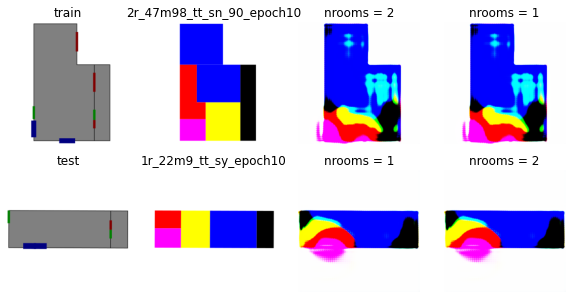

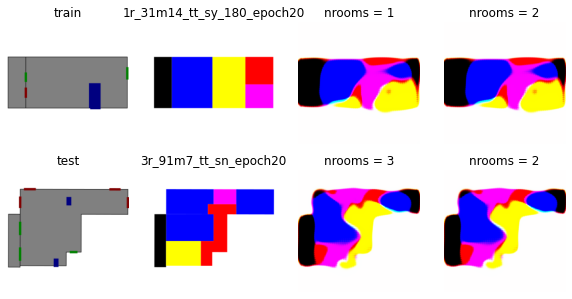

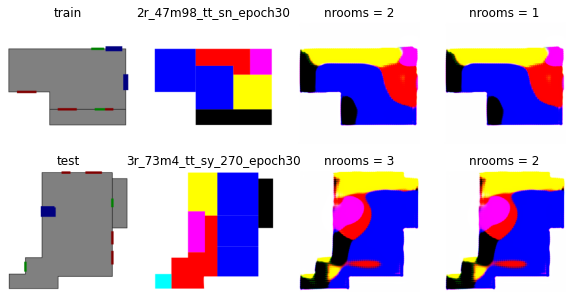

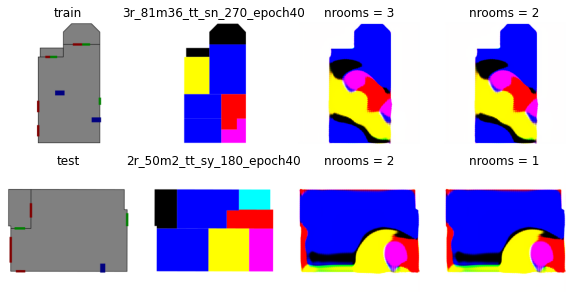

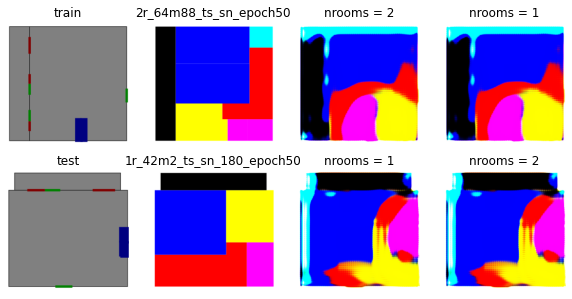

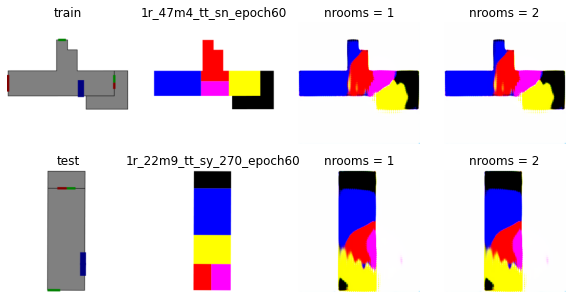

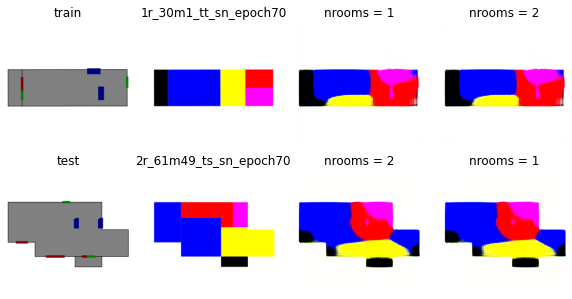

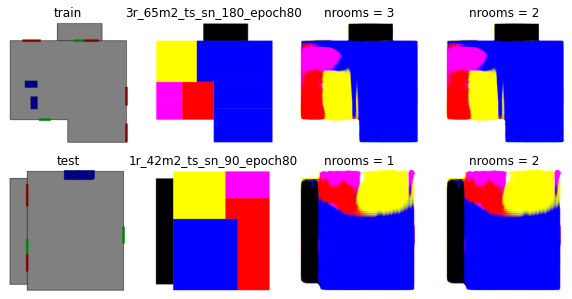

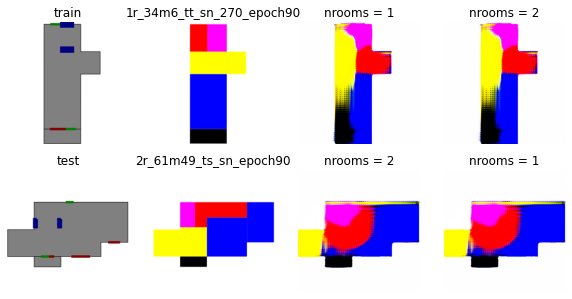

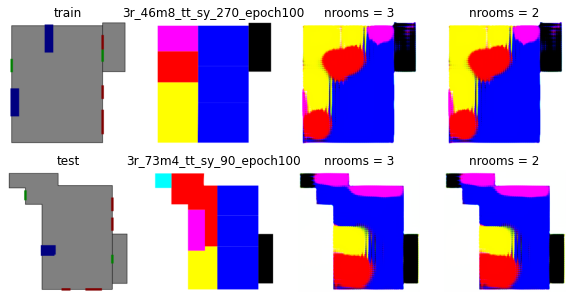

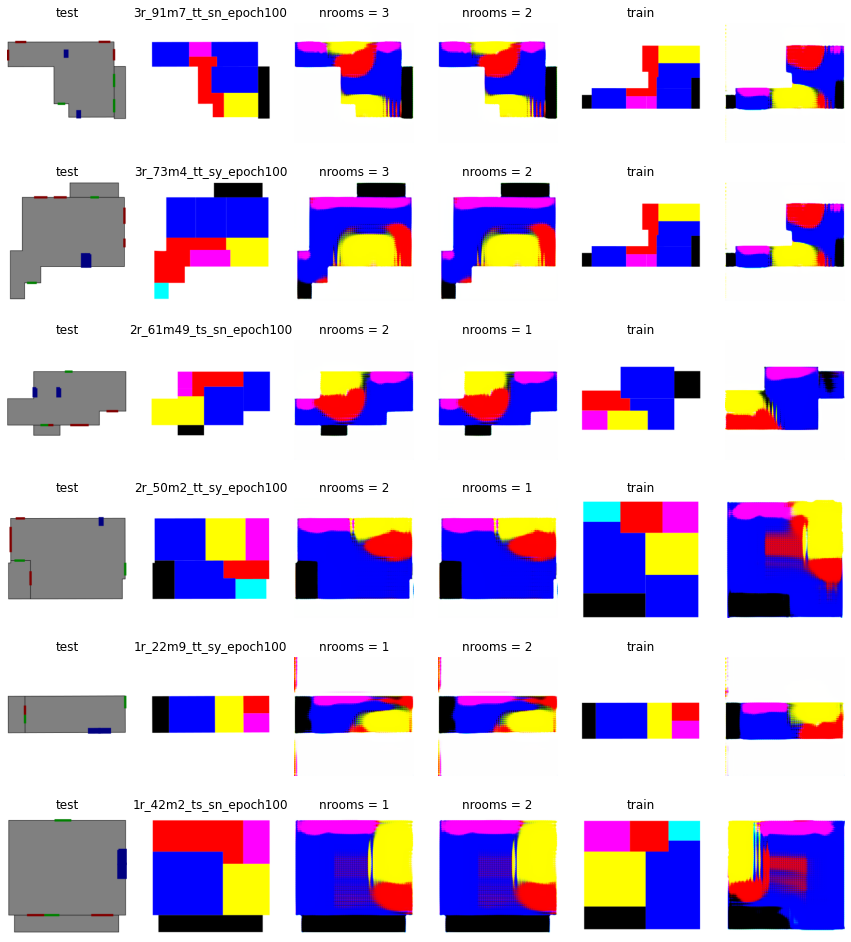

In [62]:
plt.ioff()
name = 'rotate *3, filled vent'
train((training_data_loader, testing_data_loader),
       n_epochs=100, lambda_l1=10,
       netD='n_layers', n_layers=2,
       verbose=10, n_epochs_decay=0, name=name, device=device,
       to_neptune=True)

In [61]:
neptune.stop()

Loaded model from : checkpoint/netG_model_epoch_100.pth


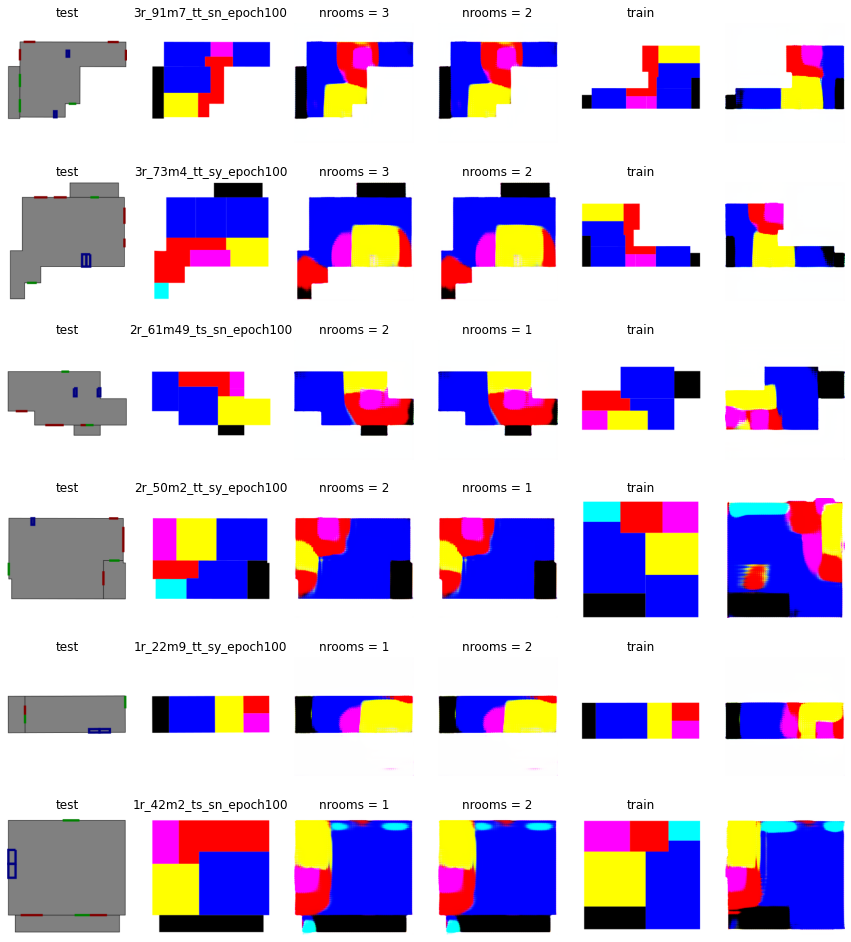

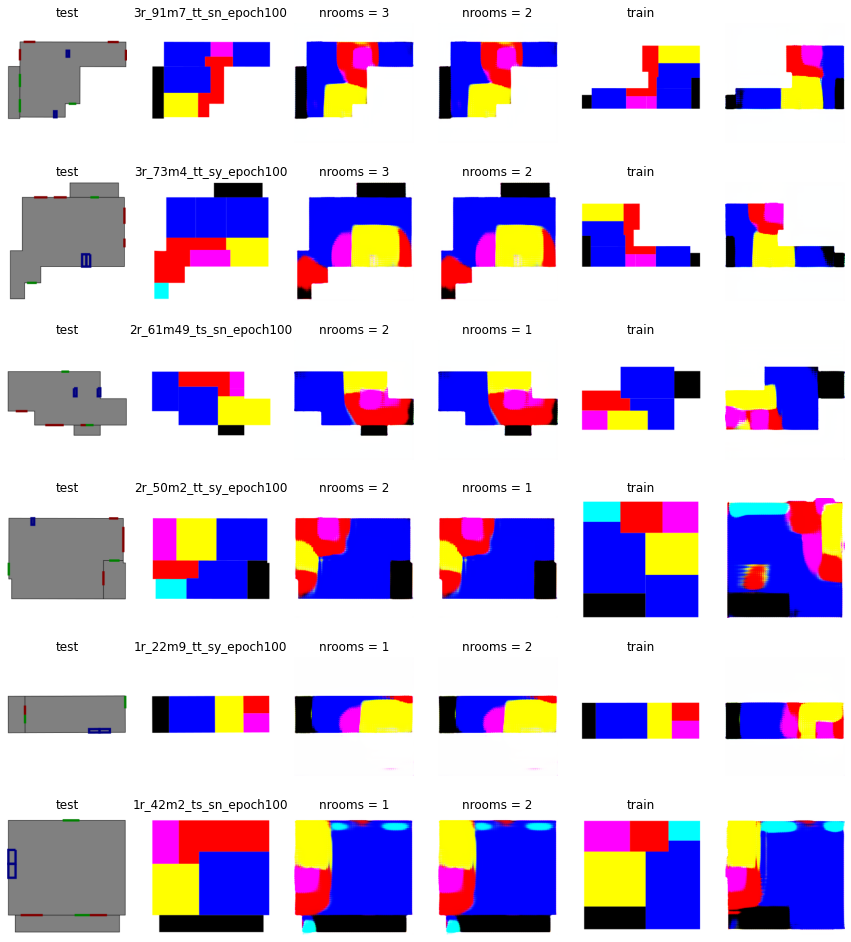

In [29]:
get_test_predictions(epoch=100)